# Gaussian Processes

In [1]:
#!wget -O bike.mat "https://www.andpotap.com/static/bike.mat"

--2023-07-31 12:57:46--  https://www.andpotap.com/static/bike.mat
Resolving www.andpotap.com (www.andpotap.com)... 69.164.216.245
Connecting to www.andpotap.com (www.andpotap.com)|69.164.216.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 434829 (425K) [application/octet-stream]
Saving to: ‘bike.mat’

bike.mat            100%[===================>] 424.64K  --.-KB/s    in 0.06s   

2023-07-31 12:57:46 (7.46 MB/s) - ‘bike.mat’ saved [434829/434829]



In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

from cola.ops import Triangular, Diagonal, Identity
from cola import jax_fns
xnp = jax_fns
dtype = xnp.float32
M1 = xnp.array([[1, 2], [3, 4]], dtype=dtype)
L  = Triangular(M1)

A, dtype, xnp = operator, operator.dtype, operator.ops
A2 = LinearOperator(A.dtype, A.shape, A._matmat)
Ainv = inverse(A, tol=1e-4)
Ainv2 = inverse(A2, tol=1e-4, method='dense')
Ainv3 = inverse(A2, tol=1e-4, method='iterative')
B = xnp.array(xnp.fixed_normal_samples((A.shape[-1], 10)), dtype=dtype)
X = Ainv @ B
rel_error = relative_error(A @ X, B)
assert rel_error < 1e-4, f"Dispatch rules failed on {type(A)}"
rel_error = relative_error(X, Ainv2 @ B)
assert rel_error < 1e-4, f"Dense inversion failed on {type(A)}"
rel_error = relative_error(X, Ainv3 @ B)
assert rel_error, f"Krylov inversion failed on {type(A)}"

NameError: name 'Triangular' is not defined

In [1]:
from jax import numpy as jnp
import os
import numpy as np
from math import floor
from scipy.io import loadmat
import cola


def load_uci_data(data_dir, dataset, train_p=0.75, test_p=0.15):
    file_path = os.path.join(data_dir, dataset + '.mat')
    data = np.array(loadmat(file_path)['data'])
    X = data[:, -2:-1]
    y = data[:, -1]

    X = X - X.min(0)[None]
    X = 2.0 * (X / X.max(0)[None]) - 1.0
    y -= y.mean()
    y /= y.std()


    train_n = int(floor(train_p * X.shape[0]))
    return X[:train_n], y[:train_n], X[train_n:], y[train_n:]



train_x, train_y, test_x, test_y = load_uci_data(data_dir="./", dataset="bike")

dtype = jnp.float32

In [2]:
def rbf(ls, uscale):
    def f(x, y):
        # (n, d) and (m, d) -> (n, m)
        inner = x@y.T
        sqdist = (x**2).sum(1).reshape(-1, 1) + (y**2).sum(1) - 2*inner
        return uscale*jnp.exp(-sqdist / ls**2)
    return f

In [3]:
train_x  = train_x[:4000]
train_y  = train_y[:4000]

In [4]:
noise = 1e-2
kernel = rbf(ls=1, uscale=1.)

Kxx= cola.ops.Dense(kernel(train_x, train_x))
Kzx = cola.ops.Dense(kernel(test_x, train_x))
Kzz = cola.ops.Dense(kernel(test_x, test_x))
K = cola.PSD(Kxx + noise * cola.ops.I_like(Kxx))
invK = cola.inverse(K)
mu = Kzx@invK@train_y
Sigma = Kzz - Kzx@invK@Kzx.T

/data/users/marc_f/cola/cola/jax_fns.py:205: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(arr, dtype=dtype)


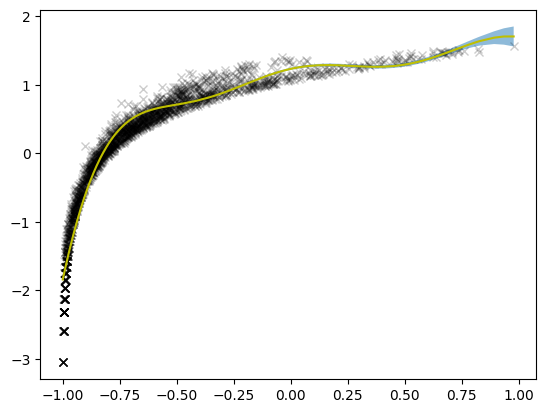

In [5]:
std = jnp.sqrt(cola.diag(Sigma,method='exact'))
import matplotlib.pyplot as plt
order = np.argsort(test_x.reshape(-1))
plt.plot(train_x.reshape(-1), train_y, 'kx', alpha=.2)
plt.plot(test_x[order].reshape(-1), mu[order], 'y')
plt.fill_between(test_x[order].reshape(-1), (mu - 2*std)[order], (mu + 2*std)[order], alpha=.5, interpolate=True)


In [4]:
# compute the MLL
y = train_y
def NLL(params, key):
    ls,uscale,noise = params
    kernel = rbf(ls, uscale)
    Kxx= cola.ops.Dense(kernel(train_x, train_x))
    K = cola.PSD(Kxx + noise * cola.ops.I_like(Kxx))
    invK = cola.inverse(K)
    minus2MLL =y.T@(invK@y)+cola.logdet(K,key=key)+jnp.log(2*jnp.pi)*y.shape[0]
    return minus2MLL/(2*y.shape[0])

In [13]:
import jax
params = (1.,1.,1e-2)
nll, grads  = jax.value_and_grad(NLL)(params,jax.random.PRNGKey(1))

/data/users/marc_f/cola/cola/jax_fns.py:205: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(arr, dtype=dtype)
/data/users/marc_f/cola/cola/jax_fns.py:205: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(arr, dtype=dtype)


In [6]:
import optax
import jax
# create the training loop

ls, uscale, noise = 1., 1., 1e-2
ls, uscale, noise = .2, .5, 1e-1
opt = optax.adam(3e-2)

@jax.jit
def step(params,opt_state, key):
    loss, grads = jax.value_and_grad(NLL)(params, key)
    key = jax.random.split(key)[0]
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, key

params = map(jnp.array,(ls,uscale,noise))
opt_state = opt.init(params)
key = jax.random.PRNGKey(0)
for i in range(5):
    params,opt_state,loss,key = step(params,opt_state,key)
    print(loss,params)

/data/users/marc_f/cola/cola/jax_fns.py:205: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(arr, dtype=dtype)
/data/users/marc_f/cola/cola/jax_fns.py:205: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(arr, dtype=dtype)


-0.07841547 (Array(0.16999932, dtype=float32), Array(0.5300007, dtype=float32), Array(0.06999931, dtype=float32))


/data/users/marc_f/cola/cola/jax_fns.py:205: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(arr, dtype=dtype)
/data/users/marc_f/cola/cola/jax_fns.py:205: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(arr, dtype=dtype)


-0.21913582 (Array(0.14007495, dtype=float32), Array(0.56002223, dtype=float32), Array(0.04005584, dtype=float32))


/data/users/marc_f/cola/cola/jax_fns.py:205: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(arr, dtype=dtype)
/data/users/marc_f/cola/cola/jax_fns.py:205: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(arr, dtype=dtype)


-0.40465352 (Array(0.11051234, dtype=float32), Array(0.5901115, dtype=float32), Array(0.01021663, dtype=float32))
-0.48636714 (Array(0.08558533, dtype=float32), Array(0.6192804, dtype=float32), Array(0.02005403, dtype=float32))
-0.5804261 (Array(0.06000623, dtype=float32), Array(0.6478058, dtype=float32), Array(0.02576736, dtype=float32))


/data/users/marc_f/cola/cola/jax_fns.py:205: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(arr, dtype=dtype)


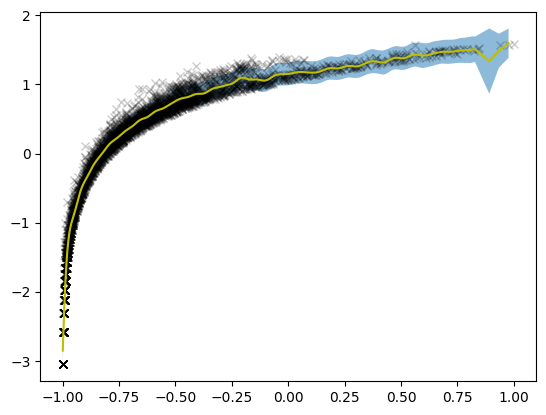

In [8]:
ls,uscale,noise = params
kernel = rbf(ls=ls, uscale=uscale)

Kxx= cola.ops.Dense(kernel(train_x, train_x))
Kzx = cola.ops.Dense(kernel(test_x, train_x))
Kzz = cola.ops.Dense(kernel(test_x, test_x))
K = cola.PSD(Kxx + noise * cola.ops.I_like(Kxx))
invK = cola.inverse(K)
mu = Kzx@invK@train_y
Sigma = Kzz - Kzx@invK@Kzx.T + noise * cola.ops.I_like(Kzz)
std = jnp.sqrt(cola.diag(Sigma,method='exact'))

import matplotlib.pyplot as plt
order = np.argsort(test_x.reshape(-1))
plt.plot(train_x.reshape(-1), train_y, 'kx', alpha=.2)
plt.plot(test_x[order].reshape(-1), mu[order], 'y')
plt.fill_between(test_x[order].reshape(-1), (mu - std)[order], (mu + std)[order], alpha=.5, interpolate=True)


In [ ]:
import logging
logging.getLogger().setLevel(logging.INFO)